# Orientation and Phase Mapping with `py4DSTEM.process.diffraction`

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (cophus@gmail.com)

### Data Availability

Tutorial files:
- [Ti550_005_downsampled.h5 dataset](https://drive.google.com/file/d/1ASIrVm4DOr_S_UkTq-t-a8xKZVK3Y4qx/view)
- [Ti alpha phase cif](https://drive.google.com/file/d/1fCdjtZ_hsjAqRvLTr4rAnEwRSRBh4W5_/view)
- [Ti beta phase cif](https://drive.google.com/file/d/1rSNfab0NuO8ZlONFw1tU8lmXUZudFAc-/view)


The dataset used for this tutorial is taken from this manuscript:
- https://doi.org/10.1111/jmi.13275

The original data files can be be found here:
- https://doi.org/10.5525/gla.researchdata.1514

Note that for the purposes of this tutorial, the data has been binned in Fourier space by a factor of 4. We have also substantially lowered the accuracy of the orientation mapping in order for this notebook tutorial to run quickly.

### Notebook contents

- load PED 4D-STEM data
- detects all Bragg peaks for each probe position
- Calibrates the origin for each probe position
- Performs orientation mapping for alpha and beta Ti.
- Generates a phase map showing where the sample has alpha and beta structure.

In [ ]:
# Install requirements
!pip install py4DSTEM pymatgen > /dev/null 2>&1
# !pip install git+https://github.com/py4DSTEM/py4DSTEM.git@dev pymatgen > /dev/null 2>&1
# !pip install git+https://github.com/cophus/py4DSTEM.git@diffraction pymatgen > /dev/null 2>&1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM as p4
print(p4.__version__)

0.14.16


In [ ]:
# Get the 4DSTEM dataset and vacuum probe image
p4.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1ASIrVm4DOr_S_UkTq-t-a8xKZVK3Y4qx',
    destination = '/content/',
    filename = 'Ti550_005_downsampled.h5',
    overwrite=True,
)
p4.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1fCdjtZ_hsjAqRvLTr4rAnEwRSRBh4W5_',
    destination = '/content/',
    filename = 'Ti_hcp.cif',
    overwrite=True,
)
p4.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1rSNfab0NuO8ZlONFw1tU8lmXUZudFAc-',
    destination = '/content/',
    filename = 'Ti_bcc.cif',
    overwrite=True,
)

Downloading...
From (original): https://drive.google.com/uc?id=1ASIrVm4DOr_S_UkTq-t-a8xKZVK3Y4qx
From (redirected): https://drive.google.com/uc?id=1ASIrVm4DOr_S_UkTq-t-a8xKZVK3Y4qx&confirm=t&uuid=81c8ead7-9911-4e0b-8dce-e97d3c93ea4e
To: /content/Ti550_005_downsampled.h5
100%|██████████| 313M/313M [00:02<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fCdjtZ_hsjAqRvLTr4rAnEwRSRBh4W5_
To: /content/Ti_hcp.cif
100%|██████████| 1.20k/1.20k [00:00<00:00, 3.19MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rSNfab0NuO8ZlONFw1tU8lmXUZudFAc-
To: /content/Ti_bcc.cif
100%|██████████| 2.95k/2.95k [00:00<00:00, 7.32MB/s]


In [ ]:
path = '/content/'
file_data = path + 'Ti550_005_downsampled.h5'
cif_Ti_alpha = path + 'Ti_hcp.cif'
cif_Ti_beta = path + 'Ti_bcc.cif'
file_analysis = path + 'Ti550_analysis_'
# file_data = '/Users/cophus/data/users/MaclarenIan/Ti550_005_downsampled.h5'
# file_analysis = 'Ti550_analysis_'
# cif_Ti_alpha = 'Ti_hcp.cif'
# cif_Ti_beta = 'Ti_bcc.cif'

# Load data, basic visualization

First we import the 4D-STEM dataset.  Next we will calculate and display mean and max diffraction patterns, and virtual bright and dark field images.

In [ ]:
try:
  dataset = p4.read(file_data)
except:
  dataset = p4.read(file_data)

In [ ]:
# Here we show how to manually apply the pixel size calibrations

pixel_size_inv_Ang = 0.003629 * 8
probe_step_size_Ang = 30.0

# Diffraction space
dataset.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset.calibration.set_Q_pixel_units('A^-1')

# Real space
dataset.calibration.set_R_pixel_size(probe_step_size_Ang)
dataset.calibration.set_R_pixel_units('A')

In [ ]:
# We can easily check the dataset size and calibrations:
dataset

DataCube( A 4-dimensional array of shape (100, 191, 64, 64) called 'datacube',
          with dimensions:

              Rx = [0.0,30.0,60.0,...] A
              Ry = [0.0,30.0,60.0,...] A
              Qx = [0.0,0.029032,0.058064,...] A^-1
              Qy = [0.0,0.029032,0.058064,...] A^-1
)

In [ ]:
# Mean and max diffraciton patterns, which will be stored as entries in dataset.tree()
dataset.get_dp_max();
dataset.get_dp_mean();

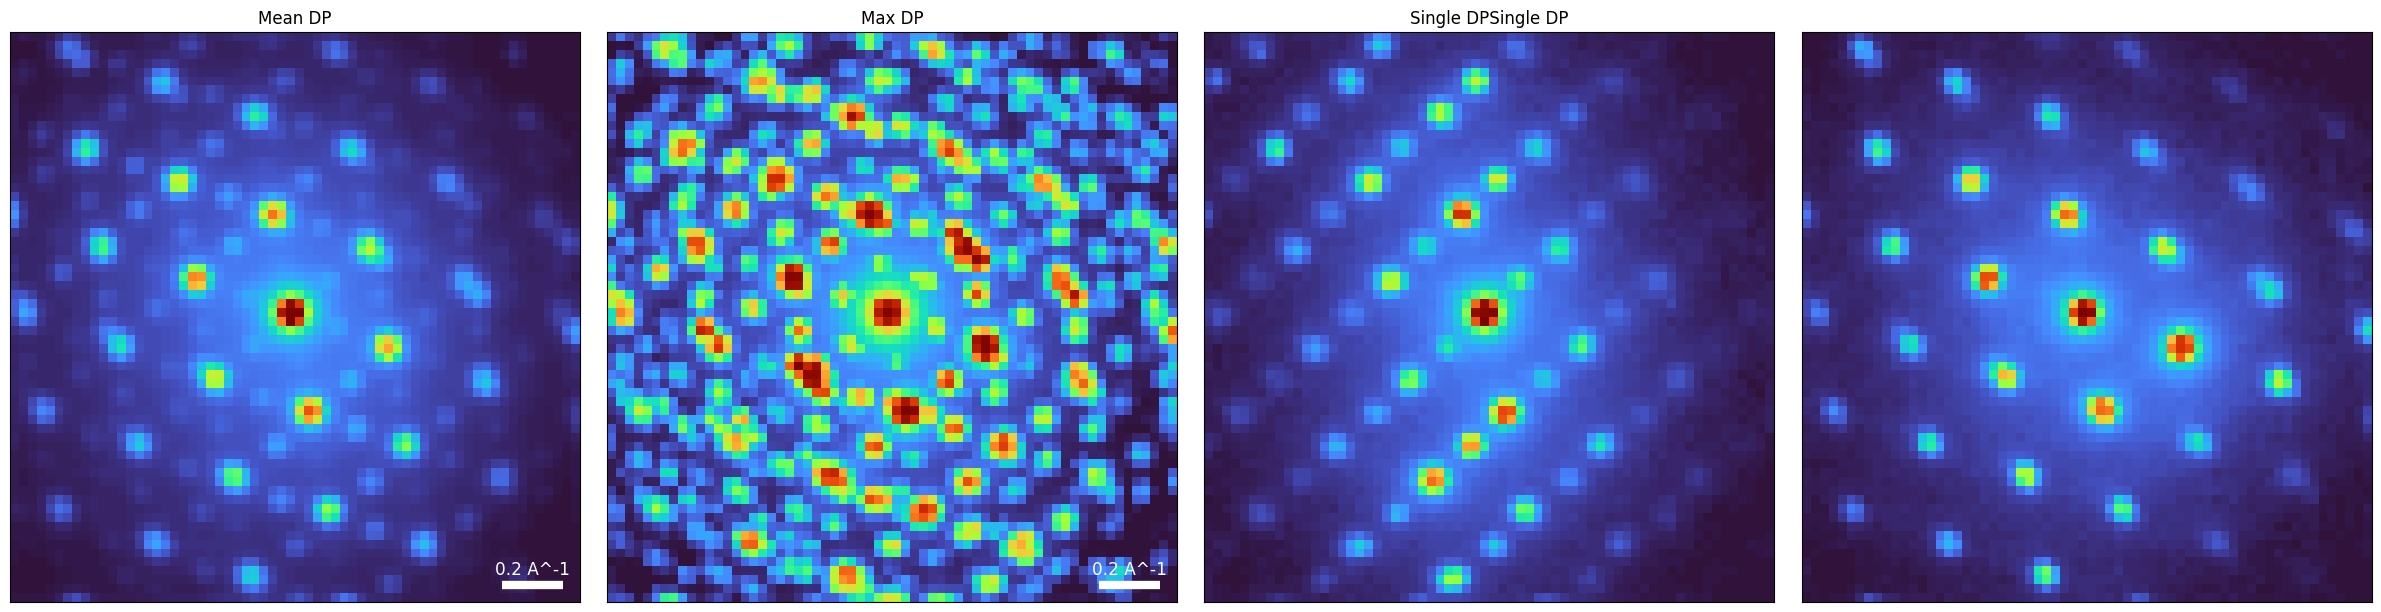

In [ ]:
# Let's compare the mean, max and individual diffraciton patterns:
p4.show(
    [
        dataset.tree('dp_mean'),
        dataset.tree('dp_max'),
        dataset.data[10,10],
        dataset.data[80,190],
    ],
    vmax=1,
    power = 0.5,
    cmap='turbo',
    ticks = False,
    title = ['Mean DP', 'Max DP', 'Single DP'  'Single DP'],
)

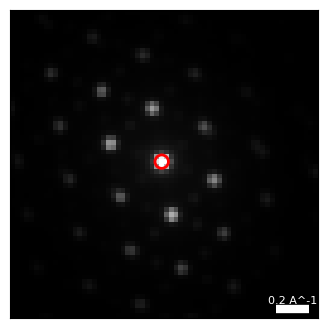

In [ ]:
# Estimate the position of the zero beam

# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    dataset.tree('dp_mean').data,
    thresh_lower=0.5,
)
center = (probe_qx0, probe_qy0)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
p4.show(
    dataset.tree('dp_mean'),
    figsize=(4,4),
    circle = {
        'center': center,
        'R': probe_semiangle,
    },
    ticks = False,
    returnfig = True,
    vmax = 1,
);

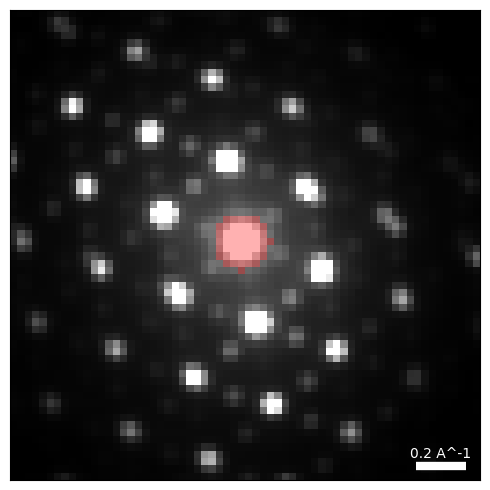

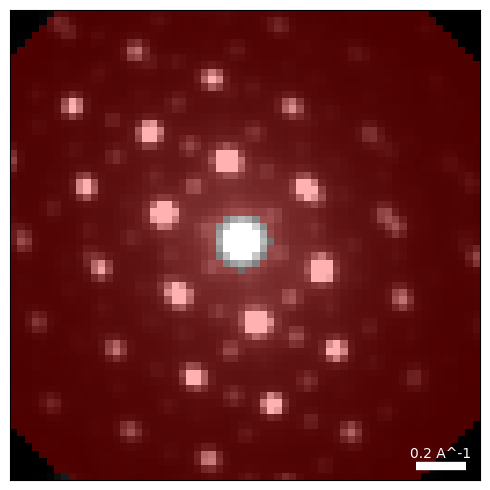

In [ ]:
# Choose the radii for some virtual detectors
radius_BF = 4
radii_ADF = (4,40)


# Plot the detectors
dataset.position_detector(
    mode = 'circular',
    geometry = (
        center,
        radius_BF,
    ),
    ticks = False,
)
dataset.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii_ADF,
    ),
    ticks = False,
)

In [ ]:
# Calculate the virtual images
dataset.get_virtual_image(
    mode = 'circular',
    geometry = ((center),radius_BF),
    name = 'bright_field',
);
dataset.get_virtual_image(
    mode = 'annular',
    geometry = ((center),radii_ADF),
    name = 'dark_field',
);

100%|██████████| 19100/19100 [00:00<00:00, 25157.28it/s]


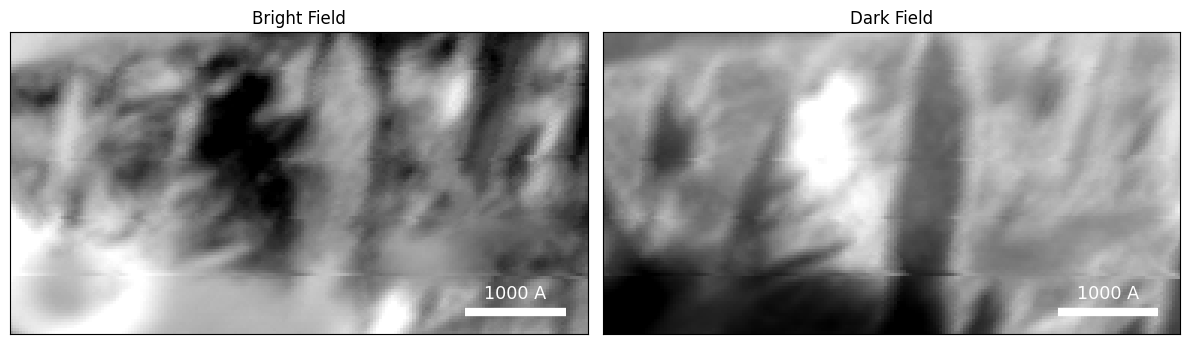

In [ ]:
# Plot the virtual images
p4.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),
    ],
    ticks = False,
    title = ['Bright Field', 'Dark Field'],
)

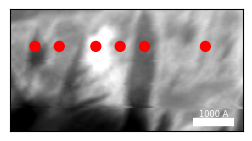

In [ ]:
# Choose some diffraction patterns to use for parameter tuning

rx = 30,30,30,30,30,30
ry = 20,40,70,90,110,160
colors=['r','r','r','r','r','r',]

p4.visualize.show_points(
    dataset.tree('dark_field'),
    x = rx,
    y = ry,
    pointcolor = colors,
    figsize = (3,4),
    ticks = False,
)

# Bragg disk detection

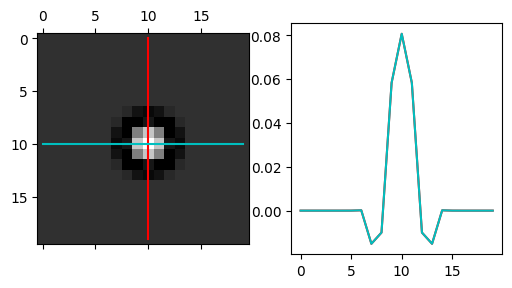

In [ ]:
# Synthetic probe template
radius = 1.5
width = 1.5

#
probe_kernel = p4.Probe.get_probe_kernel_edge_sigmoid(
    p4.Probe.generate_synthetic_probe(
        radius,
        width,
        dataset.Qshape,
    ),
    radii=(2,4.0),
)

p4.visualize.show_kernel(
    probe_kernel,
    R = 10,
    L = 10,
    W = 1,
    figsize = (6,3),
)


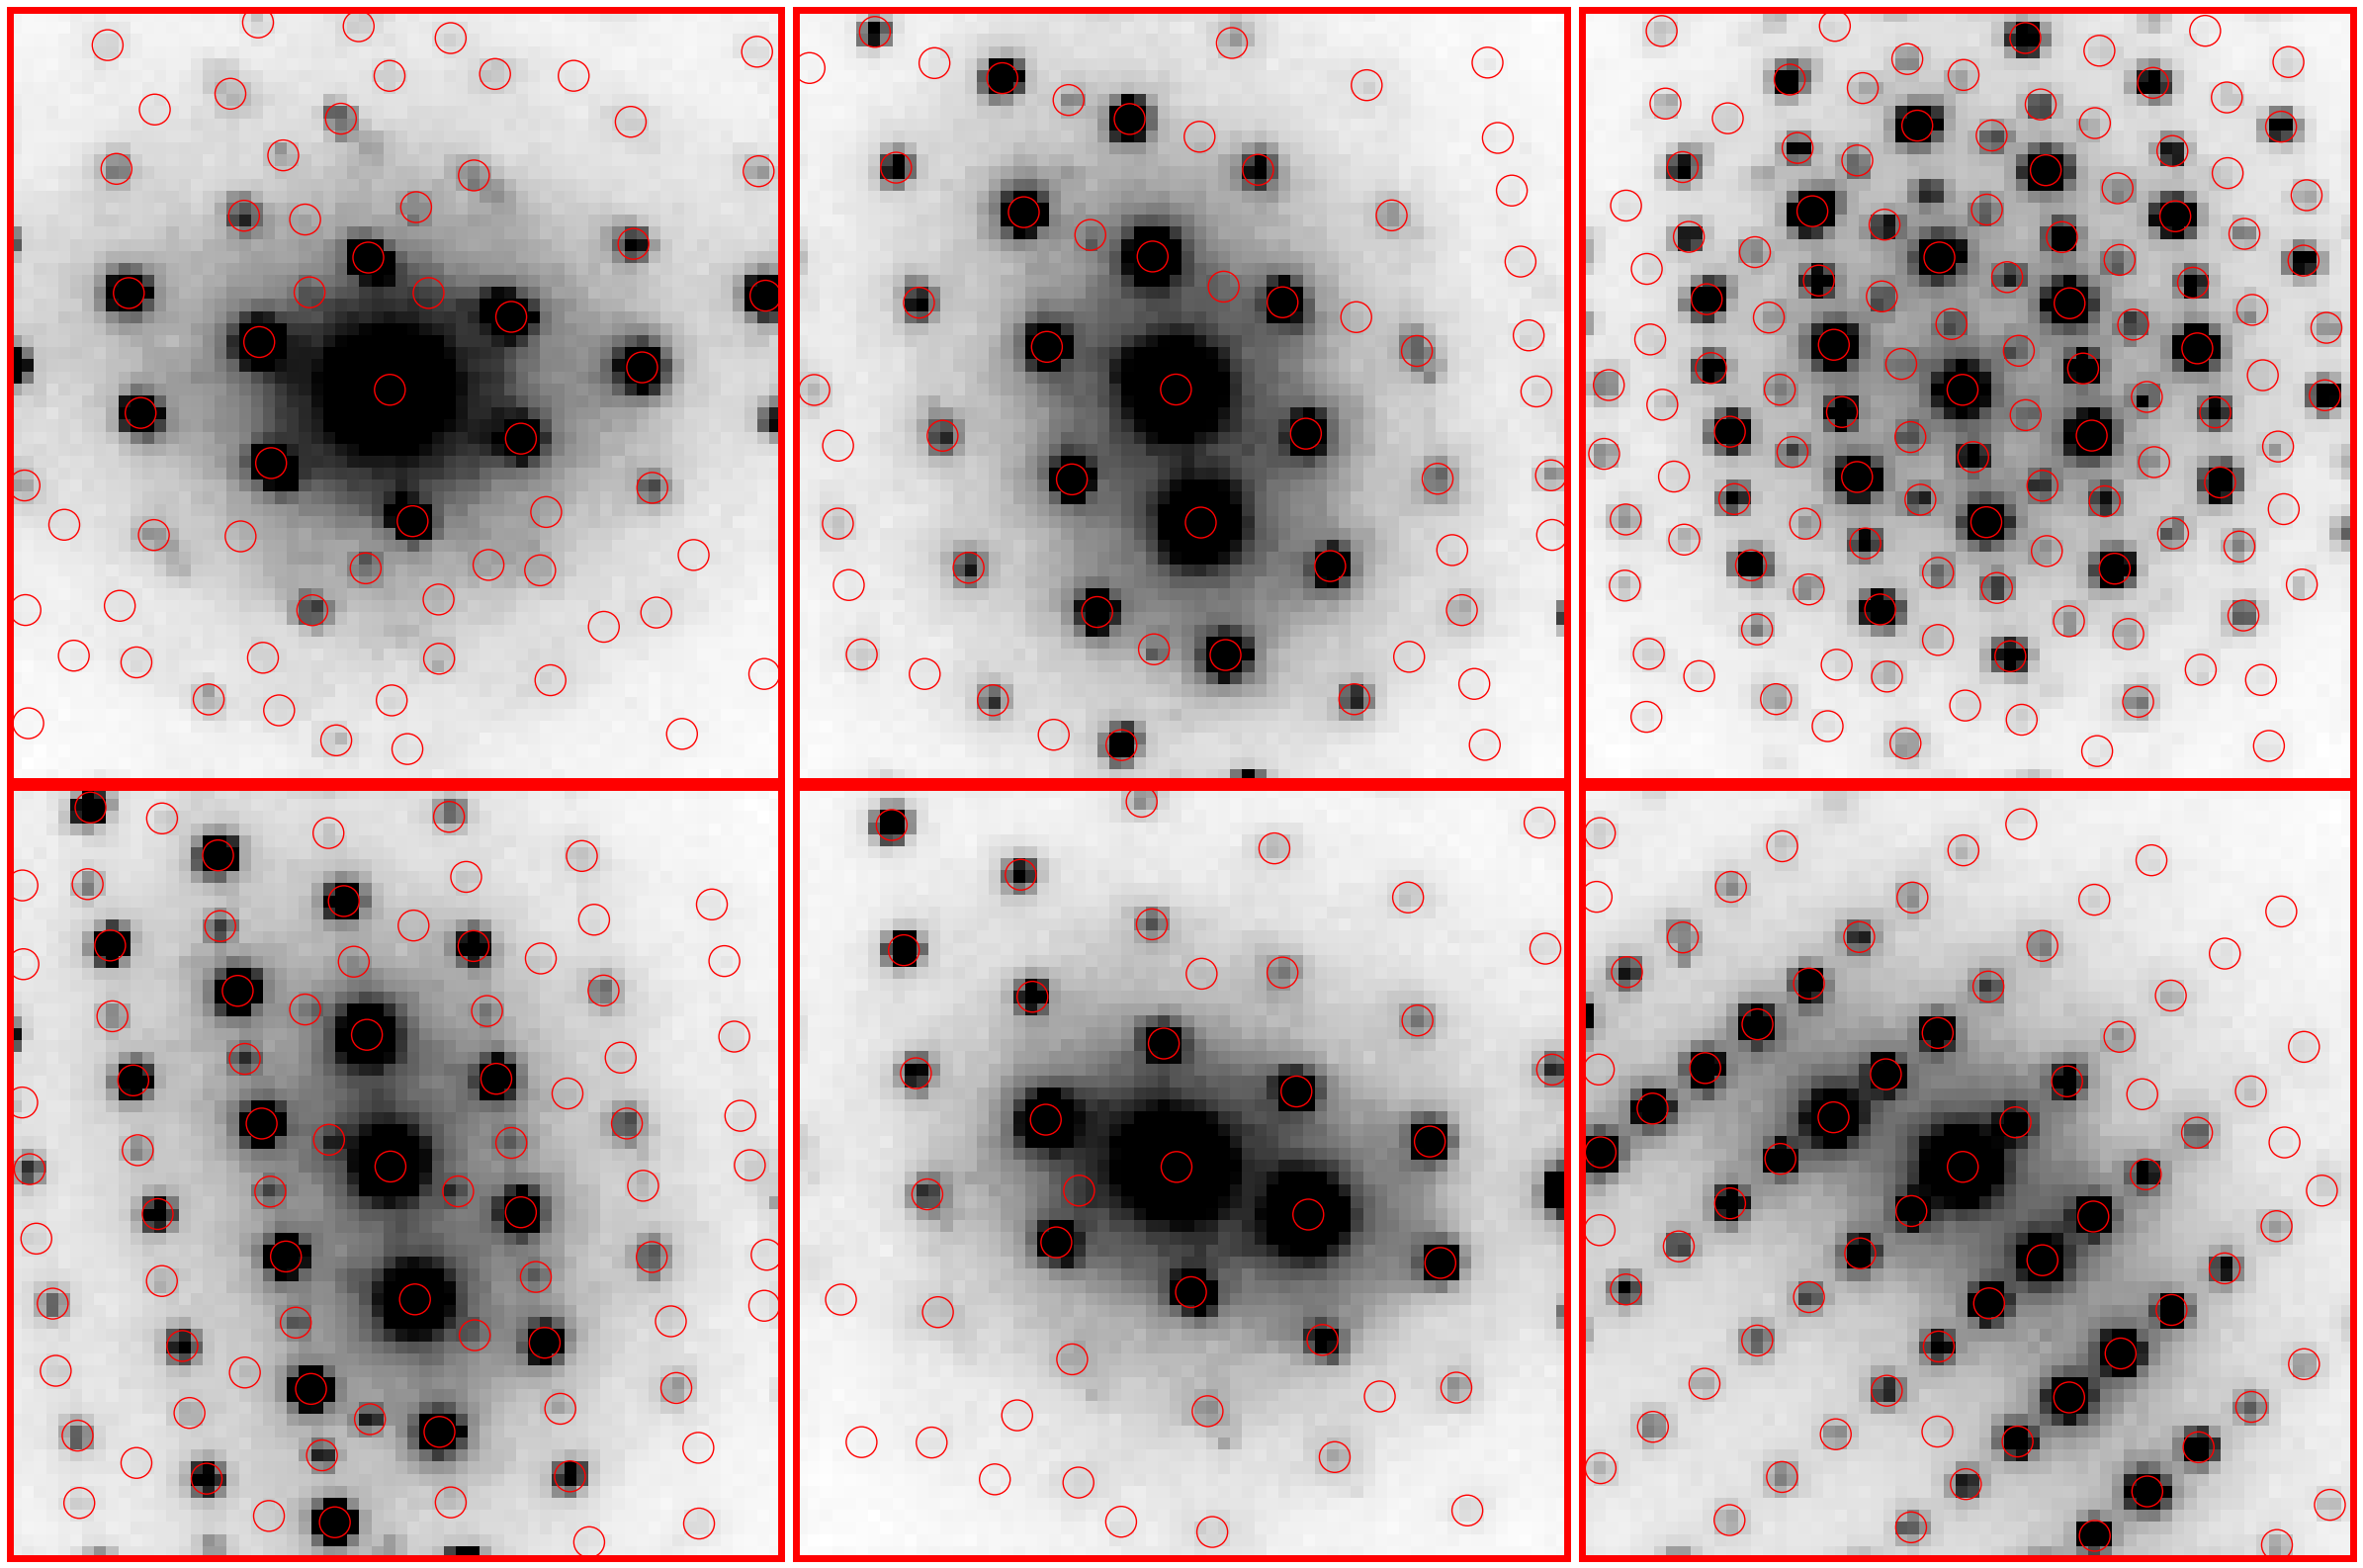

In [ ]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 1,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 12.0,
    'minPeakSpacing': 4,
    # 'subpixel' : 'multicorr',
    # 'upsample_factor': 8,
    'subpixel' : 'poly',
    'maxNumPeaks': 500,
    # 'CUDA': True,
}



disks_selected = dataset.find_Bragg_disks(
    data = (rx, ry),
    template = probe_kernel,
    **detect_params,
)

p4.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rx[i],ry[i],:,:],
    H=2,
    W=3,
    axsize=(8,8),

    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 500,

    power = 0.5,
    vmin = 0.0,
    vmax = 0.95,
    cmap = 'Greys',
)

In [ ]:
# Find Bragg peaks in all probe positions.
# Here we use "poly" which is less accurate for the subpixel Bragg peak positions, but much faster!

bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████| 19.1k/19.1k [01:19<00:00, 240DP/s]


In [ ]:
# Save disk positons
file_braggdisks_raw = file_analysis + 'braggdisks_raw.h5'
p4.save(
    file_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|██████████| 19100/19100 [00:02<00:00, 6769.71it/s]


# Centering

In [ ]:
# Reload Bragg peaks if needed
file_braggdisks_raw = file_analysis + 'braggdisks_raw.h5'
p4.print_h5_tree(file_braggdisks_raw)

/
|---datacube_root
    |---braggvectors
        |---_v_uncal




In [ ]:
# # # Uncomment to load the bragg peaks at this stage
# bragg_peaks = p4.read(
#     file_braggdisks_raw,
# )
# bragg_peaks

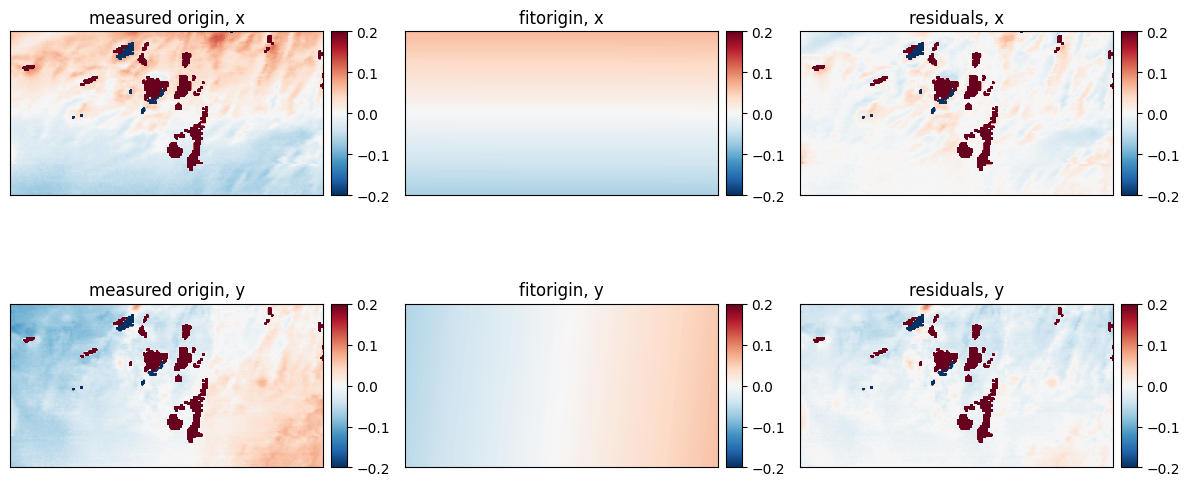

In [ ]:
# Measure the origin position.  Note the "intensity" method works well here as the zero beam is usually the brightest peak in this dataset.

# center_guess = (31,31)
origin_meas = bragg_peaks.measure_origin(
    center_guess = center,
    # score_method = 'distance',
    score_method = 'intensity',
)

# fit a 2D plane to the origin shifts (descan)
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    robust = True,
    plot_range = 0.2,
    ticks = False,
    axsize = (4,4),
)

# note that we're plotting +/-0.2 pixels, so there is not much de-scan in the data!

# Ellipticity

In [ ]:
# Assume ellipticity has already been fully corrected
bragg_peaks.calibration.set_ellipse((1,1,0))

# Rotation

In [ ]:
# Assume rotation is already corrected and the data is not transposed.
bragg_peaks.calibration.set_QR_rotation_degrees(0)
bragg_peaks.calibration.set_QR_flip(False)

# Pixel size

Calibrate data assuming most of the pixels are alpha phase Titanium (hcp).

In [ ]:
# initial guess for pixel size
inv_Ang_per_pixel = 0.039

bragg_peaks.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')
bragg_peaks.calibrate()

In [ ]:
crystal = p4.process.diffraction.Crystal.from_CIF(cif_Ti_alpha)

get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.


In [ ]:
# Calculate structure factors
k_max = 1.6

crystal.calculate_structure_factors(k_max)

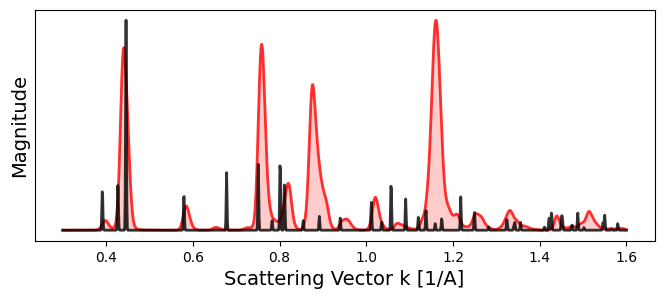

In [ ]:
# Compare measured diffraction pattern with reference crystal structures

plot_params = {
    'bragg_peaks':bragg_peaks,
    'k_power_scale':0.0,
    'k_broadening':0.001,
    'bragg_k_power':2.0,
    'bragg_k_broadening':0.005,
    'k_min':0.3,
    # 'k_max':1.3,
    'figsize':(8,3),
}

crystal.plot_scattering_intensity(**plot_params)

Calibrated pixel size = 0.03869519 A^-1


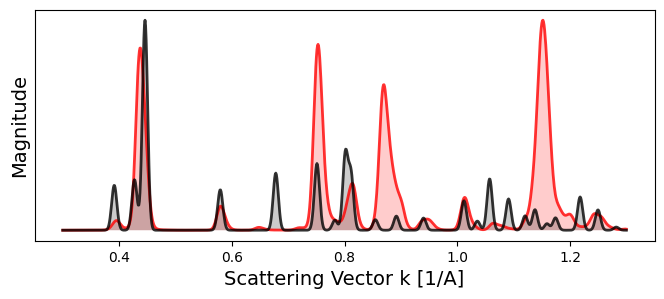

In [ ]:
bragg_peaks_calibrated = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks,
    bragg_k_power = 2.0,
    k_min = 0.3,
    k_max = 1.3,
    k_step = 0.001,
    k_broadening = 0.002,
    plot_result = True,
    fit_all_intensities = False,
    figsize = (8,3),
)

In [ ]:
# Save calibrated disk positions
file_braggdisks_cali = file_analysis + 'braggdisks_calibrated.h5'
p4.save(
    file_braggdisks_cali,
    bragg_peaks_calibrated,
    mode='o',
)

100%|██████████| 19100/19100 [00:02<00:00, 6741.15it/s]


# Orientation mapping

In [ ]:
# Reload Bragg peaks if needed
file_braggdisks_cali = file_analysis + 'braggdisks_calibrated.h5'
# file_braggdisks_cali =  '/Users/cophus/Library/CloudStorage/Dropbox/' + \
#     'PED_region02_0p4precession_orientation01_analysis_braggdisks_calibrated.h5'
p4.print_h5_tree(file_braggdisks_cali)

/
|---py4DSTEM_root
    |---braggvectors_copy
        |---_v_uncal




In [ ]:
# # Uncomment to load the bragg peaks at this stage
# bragg_peaks_calibrated = py4DSTEM.read(
#     file_braggdisks_cali,
# )
# bragg_peaks_calibrated

In [ ]:
# bragg_peaks.calibration

In [ ]:
crystal_Ti_alpha = p4.process.diffraction.Crystal.from_CIF(cif_Ti_alpha)
crystal_Ti_beta = p4.process.diffraction.Crystal.from_CIF(cif_Ti_beta)

get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.


In [ ]:
# Calculate structure factors
k_max = 1.4  # reduced structure factor to speed up tutorial

crystal_Ti_alpha.calculate_structure_factors(k_max)
crystal_Ti_beta.calculate_structure_factors(k_max)

In [ ]:
# Make orientation plans
# Note that we're doing a coarse search over 4 degree step sizes and only refining to 2 degrees.
# This is done to make the tutorial take much less time.

acom_params = {
    'zone_axis_range': 'auto',
    # 'angle_step_zone_axis': 1.0,
    # 'angle_step_in_plane': 5.0,

    'angle_step_zone_axis': 2.5,
    'angle_coarse_zone_axis': 5.0,
    'angle_refine_range': 3.0,
    'angle_step_in_plane': 10.0,

    'accel_voltage': 200e3,
    'corr_kernel_size': 0.04,
    # 'tol_peak_delete': 0.00,

    # 'power_radial':1.0,
    'power_intensity': 0.5,
    'power_intensity_experiment': 0.5,

    'sigma_excitation_error': 0.02,
    'precession_angle_degrees': 0.5,
}

crystal_Ti_alpha.orientation_plan(**acom_params)
crystal_Ti_beta.orientation_plan(**acom_params)

Automatically detected point group 6/mmm,
 using arguments: zone_axis_range = 
[[0.8660254 0.5       0.       ]
 [1.        0.        0.       ]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 703/703 [00:00<00:00, 2560.77 zone axes/s]


Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 276/276 [00:00<00:00, 2863.30 zone axes/s]


Best fit lattice directions: z axis = ([ 0.66  -0.321 -0.339  0.055]), x axis = ([ 0.447 -0.043 -0.403  0.384]), with corr value = 289.7
Best fit lattice directions: z axis = ([ 0.474 -0.054 -0.42   0.261]), x axis = ([ 0.644 -0.291 -0.353  0.056]), with corr value = 75.285
Best fit lattice directions: z axis = ([0.511 0.58  0.634]), x axis = ([0.15  0.666 0.731]), with corr value = 208.504
Best fit lattice directions: z axis = ([0.211 0.247 0.946]), x axis = ([0.298 0.399 0.867]), with corr value = 118.614


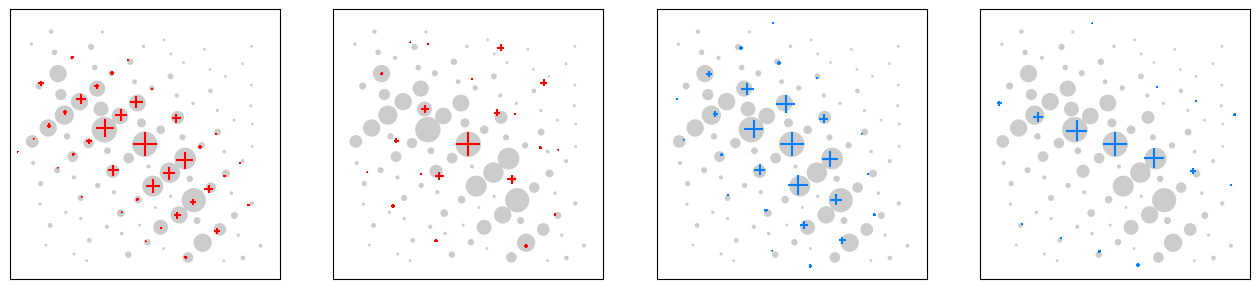

In [ ]:
# Test orientation_matching matching on some probe positions

xind, yind = 50,130
xind, yind = 50,150
# xind, yind = 50,180
# xind, yind = 30,121

min_angle_between_matches_deg = 30
precession_angle_degrees = 0.5
sigma_compare = 0.02
num_matches_return = 2


# Fit all crystals
orientation_Ti_alpha  = crystal_Ti_alpha.match_single_pattern(
    bragg_peaks_calibrated.cal[xind,yind],
    num_matches_return = num_matches_return,
    verbose = True,
    min_angle_between_matches_deg=min_angle_between_matches_deg,
)
orientation_Ti_beta  = crystal_Ti_beta.match_single_pattern(
    bragg_peaks_calibrated.cal[xind,yind],
    num_matches_return = num_matches_return,
    verbose = True,
    min_angle_between_matches_deg=min_angle_between_matches_deg,
)


# Generate test diffraction patterns for matches 0 and 1
bragg_peaks_fit_Ti_alpha_0 = crystal_Ti_alpha.generate_diffraction_pattern(
    orientation_Ti_alpha,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare,
    precession_angle_degrees = precession_angle_degrees,
)
bragg_peaks_fit_Ti_alpha_1 = crystal_Ti_alpha.generate_diffraction_pattern(
    orientation_Ti_alpha,
    ind_orientation=1,
    sigma_excitation_error=sigma_compare,
    precession_angle_degrees = precession_angle_degrees,
)

bragg_peaks_fit_Ti_beta_0 = crystal_Ti_beta.generate_diffraction_pattern(
    orientation_Ti_beta,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare,
    precession_angle_degrees = precession_angle_degrees,
)
bragg_peaks_fit_Ti_beta_1 = crystal_Ti_beta.generate_diffraction_pattern(
    orientation_Ti_beta,
    ind_orientation=1,
    sigma_excitation_error=sigma_compare,
    precession_angle_degrees = precession_angle_degrees,
)


# plotting frame
figsize = (4,4)
fig,ax = plt.subplots(1,4,figsize=(4*figsize[0],1*figsize[1]))

plot_params = {
    'bragg_peaks_compare':     bragg_peaks_calibrated.cal[xind,yind],
    # 'plot_range_kx_ky':  np.array([k_max,k_max]),
    'plot_range_kx_ky':  np.array([1.4,1.4]),
    'min_marker_size': 1,
    'max_marker_size': 300,
    'add_labels': False,

    'scale_markers': 8000,
    'scale_markers_compare': 0.02,
    'marker': '+',
    'facecolor_compare': (0.8,0.8,0.8),

    # 'color':(1,0,0),
    'edgecolor': None,
    # 'facecolor': 'none',
    'linewidth':1.5,
    'show_axes':False
}


# plot comparisons
# Ti alpha
p4.process.diffraction.plot_diffraction_pattern(
    bragg_peaks = bragg_peaks_fit_Ti_alpha_0,
    input_fig_handle=(fig,[ax[0]]),
    color = (1.0,0.0,0.0),
    **plot_params,
)
p4.process.diffraction.plot_diffraction_pattern(
    bragg_peaks = bragg_peaks_fit_Ti_alpha_1,
    input_fig_handle=(fig,[ax[1]]),
    color = (1.0,0.0,0.0),
    **plot_params,
)
# Ti beta
p4.process.diffraction.plot_diffraction_pattern(
    bragg_peaks = bragg_peaks_fit_Ti_beta_0,
    input_fig_handle=(fig,[ax[2]]),
    color = (0.0,0.5,1.0),
    **plot_params,
)
p4.process.diffraction.plot_diffraction_pattern(
    bragg_peaks = bragg_peaks_fit_Ti_beta_1,
    input_fig_handle=(fig,[ax[3]]),
    color = (0.0,0.5,1.0),
    **plot_params,
)

In [ ]:
# fig.savefig('patterns.pdf')

In [ ]:
# Fit orientation to all probe positions
num_matches_return = 1
min_angle_between_matches_deg = 30

orientation_map_Ti_alpha = crystal_Ti_alpha.match_orientations(
    bragg_peaks_calibrated,
    num_matches_return = num_matches_return,
    min_angle_between_matches_deg = min_angle_between_matches_deg,
)
orientation_map_Ti_beta = crystal_Ti_beta.match_orientations(
    bragg_peaks_calibrated,
    num_matches_return = num_matches_return,
    min_angle_between_matches_deg = min_angle_between_matches_deg,
)

Matching Orientations: 100%|██████████| 19100/19100 [01:40<00:00, 190.74 PointList/s]


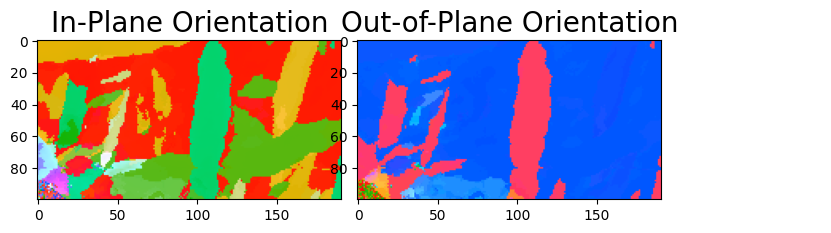

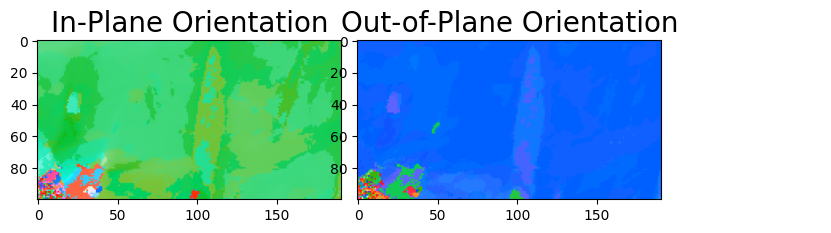

In [ ]:
# We next plot the orientation maps for both phases

c_r = (0,0.01)

im_alpha = crystal_Ti_alpha.plot_orientation_maps(
    orientation_map = crystal_Ti_alpha.orientation_map,
    corr_range = c_r,
    figsize = (8,4),
    show_legend = False,
    # camera_dist = 10,
);
im_beta = crystal_Ti_beta.plot_orientation_maps(
    orientation_map = crystal_Ti_beta.orientation_map,
    corr_range = c_r,
    figsize = (8,4),
    show_legend = False,
    # camera_dist = 10,
);

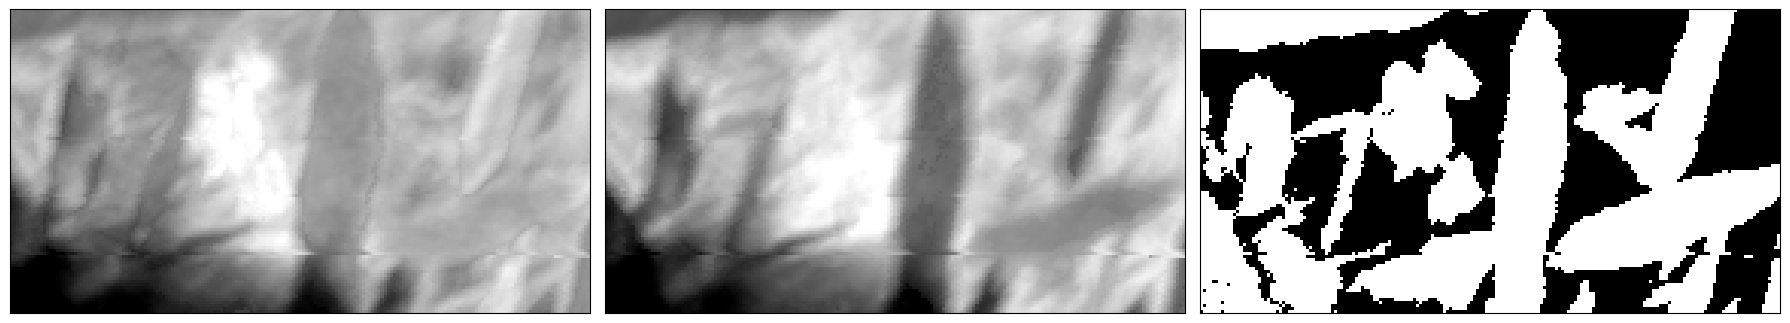

In [ ]:
# We can estimate the phase boundaries by comparing the correlation scores of the two orientation maps:
phase_alpha = crystal_Ti_alpha.orientation_map.corr[:,:,0] > crystal_Ti_beta.orientation_map.corr[:,:,0]

p4.show(
    [
        crystal_Ti_alpha.orientation_map.corr[:,:,0],
        crystal_Ti_beta.orientation_map.corr[:,:,0],
        phase_alpha,
    ],
    ticks = False,
)


# Phase mapping

In [ ]:
phase_map = p4.process.diffraction.CrystalPhase(
    crystals = [
        crystal_Ti_alpha,
        crystal_Ti_beta,
    ],
    crystal_names = [
        'Ti_alpha',
        'Ti_beta',
    ],
)

phase_weight   or_ind   name
        0.00        0   Ti_alpha    
       32.68        0   Ti_beta     
----------------------------
       32.68       fit total
       39.32    fit residual


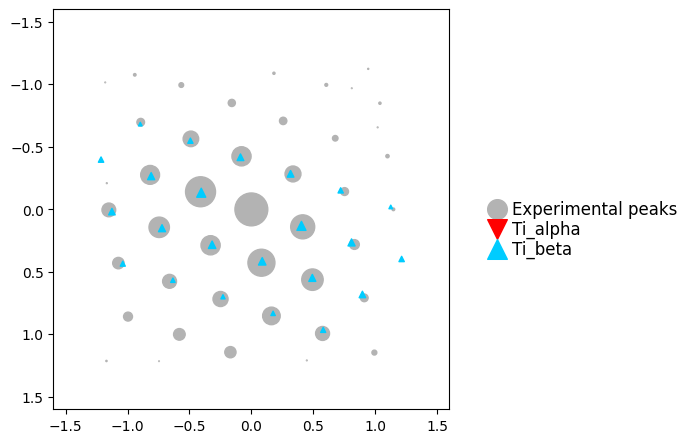

In [ ]:
phase_weights, phase_residual, phase_reliability, int_total = phase_map.quantify_single_pattern(
    bragg_peaks_calibrated,

    xy_position = (50,130),  # beta
    # xy_position = (50,150), # alpha

    single_phase = True,
    max_number_patterns = 1,
    allow_strain = False,

    corr_kernel_size = 0.04,
    sigma_excitation_error = 0.01,
    precession_angle_degrees = 0.5,

    # weight_false_positives = 0.5,

    plot_unmatched_peaks = True,
    scale_markers_experiment = 0.02,
    scale_markers_calculated = 100,
    k_max = 1.6,
    figsize = (6,4),
)

In [ ]:
phase_map.quantify_phase(
    bragg_peaks_calibrated,

    single_phase = True,
    max_number_patterns = 1,
    allow_strain = True,

    corr_kernel_size = 0.04,
    sigma_excitation_error = 0.01,
    precession_angle_degrees = 0.5,

    # weight_false_positives = 0.5,
    # power_intensity = 0.125,
    # power_intensity_experiment = 1.0,

    k_max = 1.6,
)

Quantifying Phase:  44%|████▍     | 8438/19100 [01:13<01:20, 132.75 PointList/s]

In [ ]:
mask_range = (0.0,1.0)


fig,ax = phase_map.plot_dominant_phase(
    reliability_range = mask_range,

    figsize = (8,4),
    sigma = 1,
    phase_colors = np.array([
        [1.0,0.8,0.0],
        [0.0,0.7,1.0],
    ]),

    ticks = False,
    print_fractions = True,
)

In [ ]:
# We can also generate mask images for each phase


mask = np.clip(
    (phase_map.phase_reliability - mask_range[0])
    / (mask_range[1] - mask_range[0]),0,1)
mask_alpha = mask * (phase_map.phase_weights[:,:,0] > phase_map.phase_weights[:,:,1])
mask_beta = mask * (phase_map.phase_weights[:,:,1] > phase_map.phase_weights[:,:,0])

p4.show(
    [
        mask_alpha,
        mask_beta,
    ],
    ticks = False,
    title = ['Ti alpha mask', 'Ti beta mask'],
)


In [ ]:
# Finally, we can apply the phase map masks to the orientation maps generated previously.

p4.show(
    [
        im_alpha[:,:,:,0]*mask_alpha[:,:,None],
        im_alpha[:,:,:,1]*mask_alpha[:,:,None],
    ],
    axsize = (4,2.5),
    ticks = False,
    title = [
        'Ti alpha - In-Plane Orientation',
        'Ti alpha - Out-of-Plane Orientation',
    ],
)
p4.show(
    [
        im_beta[:,:,:,0]*mask_beta[:,:,None],
        im_beta[:,:,:,1]*mask_beta[:,:,None],
    ],
    axsize = (4,2.5),
    ticks = False,
    title = [
        'Ti beta - In-Plane Orientation',
        'Ti beta - Out-of-Plane Orientation',
    ],
)